1. [Train and Test set](#Split)
2. [Decision Tree](#Dec)
3. [Naive Bayes](#NB)
4. [Knn](#Knn)
5. [Random Forest](#RF)
6. [SVC](#SVC)
7. [Visualizing the Decision Tree](#plot_DT)
8. [Bagging](#Bagging)


In [1]:
%run setup.ipynb
%run functions.ipynb

In [2]:
data = load_data("data.csv")
data = data.drop('v(g)_cat', axis=1)

In [3]:
data["v(g)_cat"] = pd.cut(data["v(g)"], bins=[min(data['v(g)'])-1, 20, max(data['v(g)'])+1], labels=[0, 1])
data["v(g)_cat"].value_counts()

0    5340
1     342
Name: v(g)_cat, dtype: int64

<a id='Def'></a> **1. Train and Test set**

In order to apply machine learning techniques the new dataset is splitted in train test and test set

Remember that dat are not homogeneous in variable "v(g)"! Let's use the function StratifiedShuffleSplit(), this algorithm provides train and test indices to split data in train and test sets. For convenience is also reported again the proportion of the two classes in the original dataset.

In [4]:
Count("v(g)_cat")

counts      %
0    5340  93.98
1     342   6.02

split the data: independent variable and label of interest

In [5]:
X = data.drop("v(g)_cat", axis=1) # drop labels for training set
y = data["v(g)_cat"].copy()

#split

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #random state is the "set_seed"

for train_index, test_index  in split.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    data_train=data.loc[train_index]
    data_test=data.loc[test_index]
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

TRAIN: [4877 2697 2556 ... 4315 3356 4177] TEST: [2336 2532 1514 ... 4501  123 4385]


In order to evaluate the goodness of this splitting, let's compare the proportion of the  class in the original dataset, in the stratified test just generated and with a random sampling.

In [7]:
prop(data, data_train, data_test, "v(g)_cat")

   Overall  Stratified    Random  Rand. %error  Strat. %error
0  0.93981    0.940193  0.938434     -0.146354       0.040813
1  0.06019    0.059807  0.061566      2.285176      -0.637257


The test set generated using stratisfied sampling has the proportions almost identical to those in the full dataset.

Some ML techniques do not perform well when the input have different scales:

In [8]:
X_train.describe().loc[['min','max']]

loc  ev(g)  iv(g)       n          v     l       d        i  \
min     1.0    1.0    1.0     1.0        0.0   0.0     0.0      0.0   
max  1882.0  133.0  219.0  5669.0  1534564.0  38.0  9773.0  29368.0   

               e      b  ...  lOCode  lOComment  lOBlank  uniq_Op  uniq_Opnd  \
min          0.0    0.0  ...     1.0        0.0      0.0      0.0        0.0   
max  149968432.0  512.0  ...  1599.0      344.0    202.0    411.0     1026.0   

     total_Op  total_Opnd  branchCount  defects   v(g)  
min       0.0         0.0          1.0      0.0    1.0  
max    3368.0      2301.0        503.0      1.0  404.0  

[2 rows x 21 columns]

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = data.columns[0:21])

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loc          4545 non-null   float64
 1   ev(g)        4545 non-null   float64
 2   iv(g)        4545 non-null   float64
 3   n            4545 non-null   float64
 4   v            4545 non-null   float64
 5   l            4545 non-null   float64
 6   d            4545 non-null   float64
 7   i            4545 non-null   float64
 8   e            4545 non-null   float64
 9   b            4545 non-null   float64
 10  t            4545 non-null   float64
 11  lOCode       4545 non-null   float64
 12  lOComment    4545 non-null   float64
 13  lOBlank      4545 non-null   float64
 14  uniq_Op      4545 non-null   float64
 15  uniq_Opnd    4545 non-null   float64
 16  total_Op     4545 non-null   float64
 17  total_Opnd   4545 non-null   float64
 18  branchCount  4545 non-null   float64
 19  defect

Verify that the mean of each feature (column) is 0.

In [11]:
X_train.mean(axis = 0)

loc           -1.050376e-18
ev(g)          6.054807e-16
iv(g)          3.862575e-16
n              6.351111e-18
v             -6.082410e-18
l             -2.937633e-16
d              3.603034e-18
i             -2.426246e-17
e              1.087017e-17
b             -2.165485e-17
t             -5.111423e-18
lOCode         2.398766e-17
lOComment      2.421972e-16
lOBlank       -2.911740e-17
uniq_Op       -5.523024e-17
uniq_Opnd     -2.279560e-16
total_Op      -1.742891e-17
total_Opnd    -4.922111e-17
branchCount    3.143800e-17
defects        4.459945e-16
v(g)           8.111101e-17
dtype: float64

Verify that the std of each feature (column) is 1

In [12]:
X_train.std(axis = 0)

loc            1.00011
ev(g)          1.00011
iv(g)          1.00011
n              1.00011
v              1.00011
l              1.00011
d              1.00011
i              1.00011
e              1.00011
b              1.00011
t              1.00011
lOCode         1.00011
lOComment      1.00011
lOBlank        1.00011
uniq_Op        1.00011
uniq_Opnd      1.00011
total_Op       1.00011
total_Opnd     1.00011
branchCount    1.00011
defects        1.00011
v(g)           1.00011
dtype: float64

**CLASSIFIER:** 

<a id='Dec'></a> **2. Decision Tree:**

In [13]:
tree_clf= DecisionTreeClassifier() #classifier
tree_clf.fit(X_train,y_train) #training the model
tree_pred=tree_clf.predict(X_test) #predict the variable y

confusion matrix and accuracy

In [14]:
tree_mtx = confusion_matrix(y_test, tree_pred)
tree_acc = accuracy_score(y_test, tree_pred)
print(tree_mtx)
round(tree_acc*100,3)


[[   0 1069]
 [   0   68]]


5.981

A perfect classifier would have only true positives and true negatives, so the confusion matrix would have non zero values only on its main diagonal.

How do you interpret accuracy scores?
Accuracy represents the number of correctly classified data instances over the total number of data instances. very low!! Accuracy is not always a good performance metric for classifiers, especially when you are dealing with skewed datasets.

Let's use also cross-validation to have an idea of how good our model is. The cross-validation approach  uses different portions of the data to test and train a model on different iterations. You can use the cross_val_score function to randomly splits the training set into k distinct subsets called folds, then it trains and evaluates a model k times, picking a different fold for evaluation every time and training on the other k-1 folds. In the following code, k is set to 10. The result is an array containing the 10 evaluation scores.

In [15]:
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=10)
round(tree_scores.mean()*100,3)

100.0

In [16]:
 def display_scores(scores):
    print("Scores:", tree_scores)
    print("Mean:", tree_scores.mean())
    print("Standard deviation:", tree_scores.std())

display_scores(tree_scores)

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard deviation: 0.0


<a id='plot_DT'></a> **7. Visualizing the Decision Tree**

In [19]:
export_graphviz(tree_clf, out_file=os.path.join(IMAGES_PATH, "tree2.dot"), feature_names=list(data.columns[0:21]),rounded=True, filled=True)

In [20]:
(graph,) = pydot.graph_from_dot_file(os.path.join(IMAGES_PATH, "tree2.dot"))
graph.write_png(os.path.join(IMAGES_PATH, "tree2.png"))

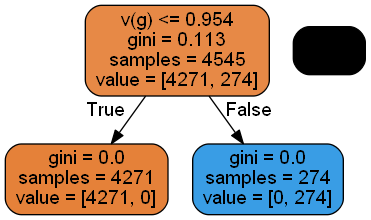

<a id='NB'></a> **3. Naive Bayes:**

In [21]:
Naive_clf = GaussianNB()
Naive_clf.fit(X_train,y_train)
Naive_pred=Naive_clf.predict(X_test)

confusion matrix and accuracy

In [22]:
Naive_mtx = confusion_matrix(y_test, Naive_pred)
Naive_acc = accuracy_score(y_test, Naive_pred)
print(Naive_mtx)
round(Naive_acc*100,3)

[[   0 1069]
 [   0   68]]


5.981

equal to before!!

In [23]:
Naive_scores = cross_val_score(Naive_clf, X_train, y_train, cv=10)
round(Naive_scores.mean()*100,3)

96.04

In [24]:
display_scores(Naive_scores)

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard deviation: 0.0


<a id='Knn'></a> **4. Knn:**

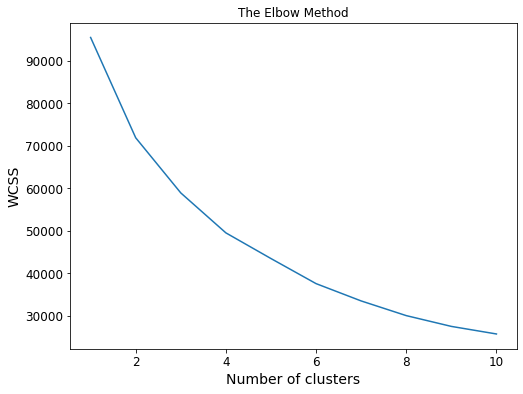

In [25]:
#elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [26]:
Knn_clf = KNeighborsClassifier(n_neighbors = 4) 
Knn_clf.fit(X_train, y_train)
Knn_pred=Knn_clf.predict(X_test)

confusion matrix and accuracy

In [27]:
Knn_mtx = confusion_matrix(y_test, Knn_pred)
Knn_acc = accuracy_score(y_test, Knn_pred)
print(Knn_mtx)
round(Knn_acc*100,3)

[[  21 1048]
 [   0   68]]


7.828

In [28]:
Knn_scores = cross_val_score(Knn_clf, X_train, y_train, cv=10)
round(Knn_scores.mean()*100,3)

98.02

In [29]:
display_scores(Knn_scores)

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard deviation: 0.0


<a id='RF'></a> **5. Random Forest:**

 Let's try with a RandomForestClassifier:

In [30]:
forest_clf= RandomForestClassifier() #classifier
forest_clf.fit(X_train,y_train) #training the model
forest_pred=forest_clf.predict(X_test) #predict the variable y

confusion matrix and accuracy

In [31]:
forest_mtx = confusion_matrix(y_test, forest_pred)
forest_acc = accuracy_score(y_test, forest_pred)
print(forest_mtx)
round(forest_acc*100,3)

[[   0 1069]
 [   0   68]]


5.981

In [32]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
round(forest_scores.mean()*100,3)

100.0

In [33]:
display_scores(forest_scores)

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard deviation: 0.0


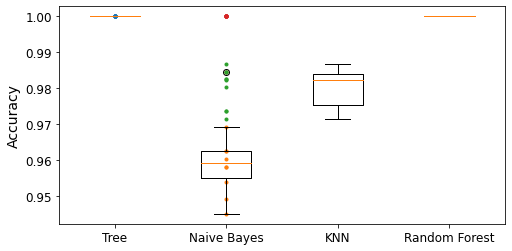

In [34]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, tree_scores, ".")
plt.plot([2]*10, Naive_scores, ".")
plt.plot([2]*10, Knn_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([tree_scores, Naive_scores, Knn_scores, forest_scores], labels=("Tree", "Naive Bayes", "KNN", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

NAive BAyes has a very big spread. Tree and random Forest are a 100% of accuracy. Svc is better than Knn

<a id='SVC'></a> **6. SVC:**

Support vector machines is only a binary classifier!! It's possible to use the approach that consider 1 classes versus the other one using SVC (OneVsOneClassifier)

In [35]:
svc_clf = OneVsRestClassifier(SVC(gamma="auto"))
svc_clf.fit(X_train, y_train)
svc_pred= svc_clf.predict(X_test)

confusion matrix and accuracy

In [36]:
svc_mtx = confusion_matrix(y_test, svc_pred)
svc_acc = accuracy_score(y_test, svc_pred)
print(svc_mtx)
round(svc_acc*100,3)

[[   2 1067]
 [   0   68]]


6.157

VOTING CLASSIFIER: the voting classifier slightly outperforms all the individual classifiers.

In [37]:
voting_clf = VotingClassifier(estimators=[('dec_tree', tree_clf), ('Naive_bayes', Naive_clf), ('Knn', Knn_clf), ('rand_for', forest_clf), ('svc', svc_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dec_tree', DecisionTreeClassifier()),
                             ('Naive_bayes', GaussianNB()),
                             ('Knn', KNeighborsClassifier(n_neighbors=4)),
                             ('rand_for', RandomForestClassifier()),
                             ('svc',
                              OneVsRestClassifier(estimator=SVC(gamma='auto')))])

In [38]:
for clf in (tree_clf, Naive_clf, Knn_clf, forest_clf, svc_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    

DecisionTreeClassifier 0.05980650835532102
GaussianNB 0.05980650835532102
KNeighborsClassifier 0.07827616534740545
RandomForestClassifier 0.05980650835532102
OneVsRestClassifier 0.06156552330694811
VotingClassifier 0.05980650835532102


 Note: the voting classifier slightly outperforms all the individual classifiers. If all the classfiers are able to estimate class probabilities, then you can predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. This approach often achieves higher performance than hard voting because it gives more weight to highly confident votes.To compute this solution you need to set voting to soft and ensure that all classifiers can estimate class probabilities. This is not the default for SVC class, so you need to create a SVC instance with the hyperparameter probability set to True.

BAGGING

<a id='Bagging'></a> **7. Bagging:**

a random forest is equal to a bag of decision trees

In [39]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples=100, bootstrap=True, n_jobs=1, random_state=42)
bag_clf.fit(X_train, y_train)
bagging_pred = bag_clf.predict(X_test)

 The BaggingClassifier performs soft voting instead of hard voting, if the base classifier can estimate class probabilities: this means use a predict_proba() method, as it is the case of the DecisionTree classifiers

In [40]:
bagging_mtx = confusion_matrix(y_test, bagging_pred)
bagging_acc = accuracy_score(y_test, bagging_pred)
print(bagging_mtx)
round(bagging_acc*100,3)

[[247 822]
 [  0  68]]


27.704

 Out-of-Bag evaluation

In [41]:
oob_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True, random_state=42)
oob_clf.fit(X_train, y_train)
oob_pred = bag_clf.predict(X_test)

In [42]:
oob_mtx = confusion_matrix(y_test, oob_pred)
oob_acc = accuracy_score(y_test, oob_pred)
print(oob_mtx)
round(oob_acc*100,3)

[[247 822]
 [  0  68]]


27.704